In [20]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm

In [2]:
TRAIN_DIR = "./train"
TEST_DIR = "./test"
IMG_SIZE = 50
LR = 0.001

In [4]:
MODEL_NAME = "catdog-{}-{}.model".format(LR, "2conv-basic")

In [9]:
def convert_to_one_hot_label(img_name):
    label = img_name.split(".")[0]
    return [1, 0] if label == "cat" else [0, 1]

In [12]:
assert convert_to_one_hot_label("cat.1234.jpg") == [1, 0]
assert convert_to_one_hot_label("dog.1234.jpg") == [0, 1]

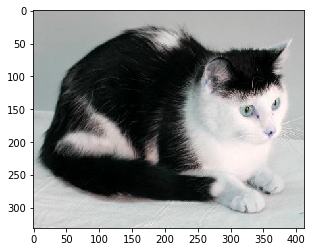

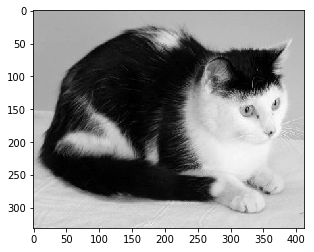

In [40]:
plt.imshow(cv2.imread("./train/cat.12345.jpg"), cmap="gray");
plt.show();
plt.imshow(cv2.imread("./train/cat.12345.jpg", cv2.IMREAD_GRAYSCALE), cmap="gray");
plt.show();
plt.close()

In [42]:
img = cv2.imread("./train/cat.12345.jpg", cv2.IMREAD_GRAYSCALE)
img.shape
img = cv2.resize(img, (50, 50))
img.shape

(331, 412)

(50, 50)

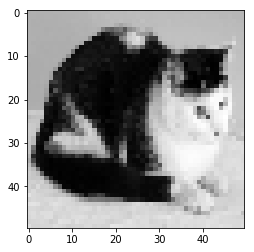

In [45]:
plt.imshow(img, cmap="gray");
plt.show();
plt.close()

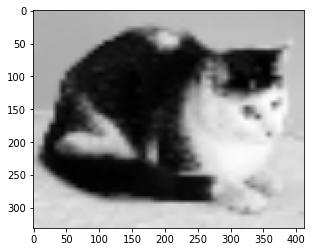

In [48]:
plt.imshow(cv2.resize(img, (412, 331)), cmap="gray");
plt.show();
plt.close()

In [61]:
def create_train_data():
    train_data = []
    for img_name in tqdm(os.listdir(TRAIN_DIR)):
        one_hot_label = convert_to_one_hot_label(img_name)
        path = os.path.join(TRAIN_DIR, img_name)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        train_data.append([img, np.array(one_hot_label)])
    np.random.shuffle(train_data)
    np.save("train_data.npy", train_data)
    return train_data

train_data = create_train_data()

100%|████████████████████████████████| 25000/25000 [00:25<00:00, 990.84it/s]


In [62]:
def create_test_data():
    test_data = []
    for img_name in tqdm(os.listdir(TEST_DIR)):
        img_type = img_name.split(".")[0]
        path = os.path.join(TEST_DIR, img_name)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        train_data.append([img, img_type])
    np.random.shuffle(test_data)
    np.save("test_data.npy", test_data)
    return train_data

test_data = create_train_data()

100%|████████████████████████████████| 25000/25000 [00:25<00:00, 985.94it/s]


In [64]:
def load_data():
    if os.path.exists("train_data.npy"):
        train_data = np.load("train_data.npy")
    else:
        train_data = create_train_data()
        
    if os.path.exists("test_data.npy"):
        test_data = np.load("test_data.npy")
    else:
        test_data = create_test_data()
        
    return train_data, test_data

In [66]:
train_data, test_data = load_data()